### Main figures - Amundsen UC
- load mooring data and compute along-trough component of velocity
    - S1
    - central trough (CT) - istar1, western trough
    - eastern trough (ET)
    
- altimetry data: EOF reconstruction

- monthly correlation maps with and without seasonal cycle
- test what the correlation maps look like for the CT period for S1 
- redo correlation maps after applying a 3-6 month running mean filter

In [1]:
# Import modules
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.dates as mdates

from scipy.stats import pearsonr

import sys

from datetime import timedelta

import gsw

In [2]:
def set_start_end_dates(arr1, arr2):
    # initialize times from array
    date_start, date_end = arr1.time[0], arr1.time[-1]
    arr2_start, arr2_end = arr2.time[0], arr2.time[-1]
    
    if arr2_start > date_start:
        date_start = arr2_start
    if arr2_end < date_end:
        date_end = arr2_end
        
    if date_end < date_start:
        print("Incorrect date interval - end date precedes start date!")
    print(date_start, date_end)
    return date_start, date_end

def crop_arrays(arr1, arr2):
    date_start, date_end = set_start_end_dates(arr1, arr2)
    arr1_crop = arr1.sel(time=slice(date_start, date_end))
    arr2_crop = arr2.sel(time=slice(date_start, date_end))
    
    return arr1_crop, arr2_crop

def plot_altim_moor_rmaps(arr0, alt0, glon, glat):
    # PLOTS
    cbar_range = [-.7, .7]
    cmap = cm.get_cmap('RdBu_r', 17)
    
    arr, alt = crop_arrays(arr0, alt0)
    
    # compute corr maps
    corr, pval = rmap.r_map_ts(alt.values,
                            arr.values)
    ds = xr.Dataset({"corr" : (("longitude", "latitude"), corr),
                "pval" : (("longitude", "latitude"), pval)},
                   coords={"longitude": alt.longitude.values,
                          "latitude": alt.latitude.values})
    
    fig, ax, m = rmap.plot_corr(corr, pval, 
                            glon, glat, cbar_range, cmap)
    return ds

In [3]:
def pearsonr_irreg(arr1, arr2):
    arr1_crop, arr2_crop = crop_arrays(arr1, arr2)
    
    r, p = pearsonr(arr1_crop.data, arr2_crop.data)
    return r, p

In [3]:
%matplotlib qt

In [4]:
#-------------------------------------------------------------------
# Directories and local functions
#-------------------------------------------------------------------
voldir = '/Volumes/SamT5/PhD/data/'
mdir = voldir + 'moorings/SWE_Dotson/'
mdir_pd = mdir + '../Currentmeters_PD_monthly/'
topodir = voldir + 'topog/'

localdir = '/Users/ocd1n16/PhD_local/'

figdir = localdir + 'paper1_draft/figs_overleaf/'

auxscriptdir = localdir + 'scripts/aux_func/'
sys.path.append(auxscriptdir)
import aux_func_trend as fc
import aux_stereoplot as st
import aux_corr_maps as rmap
import aux_matlab_func as matf

# function that extracts altimetry data
sys.path.append(localdir + 'scripts/D_validation_and_analysis/')
import d2_extract_altim_anom as altim

Defining map area ...

Getting coastlines north of 60 S ... 

Importing Antarctic Digital Database shapefile. 

KeysView(<xarray.Dataset>
Dimensions:    (lat: 56, lon: 360)
Coordinates:
  * lon        (lon) float64 180.5 181.5 182.5 183.5 ... 176.5 177.5 178.5 179.5
  * lat        (lat) float64 -77.75 -77.25 -76.75 ... -51.25 -50.75 -50.25
Data variables:
    elevation  (lon, lat) float64 ...)


In [5]:
# S1 mooring data
mfile = 's1_raw_uv_hourly_adcp_404m_540m_2010_2016.nc'
dep_min_max = [412, 540]

with xr.open_dataset(mdir + mfile) as s1moor:
    print(s1moor.keys())

s1 = s1moor.sel(depth=slice(dep_min_max[0], dep_min_max[1]))

# average data daily
s1d = s1.resample(time="1D").mean()

# - - - - - - - - - - - - - - - - -
# 15-day filter
# - - - - - - - - - - - - - - - - -
s1d_filt = s1d.rolling(time=15, min_periods=1).mean()

# projection on rotated reference frame
tim, dep = s1d.u.shape
rot_u, rot_v = [np.ones((tim, dep)) for _ in range(2)]

for i in range(dep):
    rot_vel = fc.rotate_frame(s1d_filt.u[:, i], s1d_filt.v[:, i], 45, 'clockwise')
    rot_u[:, i] = rot_vel.u.values
    rot_v[:, i] = rot_vel.v.values
    
# add new components to existing dataset
s1d_filt["rot_u"] = (("time", 'depth'), rot_u)
s1d_filt["rot_v"] = (("time", "depth"), rot_v)

# average with depth
ts1 = s1d_filt.mean("depth")

# - - - - - - - - - - - - - - - - -
# monthly averages - compare with max vel within that water column
# - - - - - - - - - - - - - - - - -
mts1 = ts1.resample(time='1MS').mean()
mts1_med = ts1.resample(time='1MS').median()

mts1_dep = s1d_filt.resample(time='1MS').mean()
mts1_max = mts1_dep.max("depth")
depth_vmax = mts1_dep.depth[mts1_dep.rot_u.argmax("depth")]

# time end points
s1_start = '2010-03-01'
s1_end = '2015-12-01'

# crop to integer number of years
uc_dep_crop = mts1.sel(time=slice(s1_start, s1_end))
uc_max_crop = mts1_max.sel(time=slice(s1_start, s1_end))

# remove linear trend
uc_dep_trend, uc_dep = fc.trend_ci(uc_dep_crop.rot_u, 0.95)
uc_max_trend, uc_max = fc.trend_ci(uc_max_crop.rot_u, 0.95)

# anomalies
uc_dep_anom = uc_dep - uc_dep.mean()
uc_dep_mclim = uc_dep.groupby("time.month") - uc_dep.groupby("time.month").mean()

uc_max_anom = uc_max - uc_max.mean()
uc_max_mclim = uc_max.groupby("time.month") - uc_max.groupby("time.month").mean()


KeysView(<xarray.Dataset>
Dimensions:  (depth: 18, time: 51839)
Coordinates:
  * time     (time) datetime64[ns] 2010-02-15T15:00:00 ... 2016-01-17T03:00:00
  * depth    (depth) float64 404.0 412.0 420.0 428.0 ... 516.0 524.0 532.0 540.0
Data variables:
    u        (time, depth) float64 ...
    v        (time, depth) float64 ...
Attributes:
    lon:      -116.358
    lat:      -72.468)


In [6]:
#------------------------------------------------------------------
#            ~ ~ ~    OTHER MOORINGS     ~ ~ ~   
#------------------------------------------------------------------
# hourly
#bsr12_0 = xr.open_dataset(mdir_pd + 'bsr12_0_raw.nc') # 400 m
bsr12_1 = xr.open_dataset(mdir_pd + 'bsr12_1_raw.nc') # 553 m
bsr13 = xr.open_dataset(mdir_pd + 'bsr13a_raw.nc') # 338 m

istar1 = xr.open_dataset(mdir_pd + 'istar1_raw.nc') # 581 m

troughW0 = xr.open_dataset(mdir_pd + 'troughW0_raw.nc') # 423 m
troughW1 = xr.open_dataset(mdir_pd + 'troughW1_raw.nc') # 555 m

troughE0 = xr.open_dataset(mdir_pd + 'troughE0_raw.nc') # 467 m
troughE1 = xr.open_dataset(mdir_pd + 'troughE1_raw.nc') # 595 m

# daily means
bsr12_d = bsr12_1.resample(time='1D').mean()
bsr13_d = bsr13.resample(time='1D').mean()
istar1_d = istar1.resample(time='1D').mean()
troughW0_d = troughW0.resample(time='1D').mean()
troughW1_d = troughW1.resample(time='1D').mean()
troughE0_d = troughE0.resample(time='1D').mean()
troughE1_d = troughE1.resample(time='1D').mean()

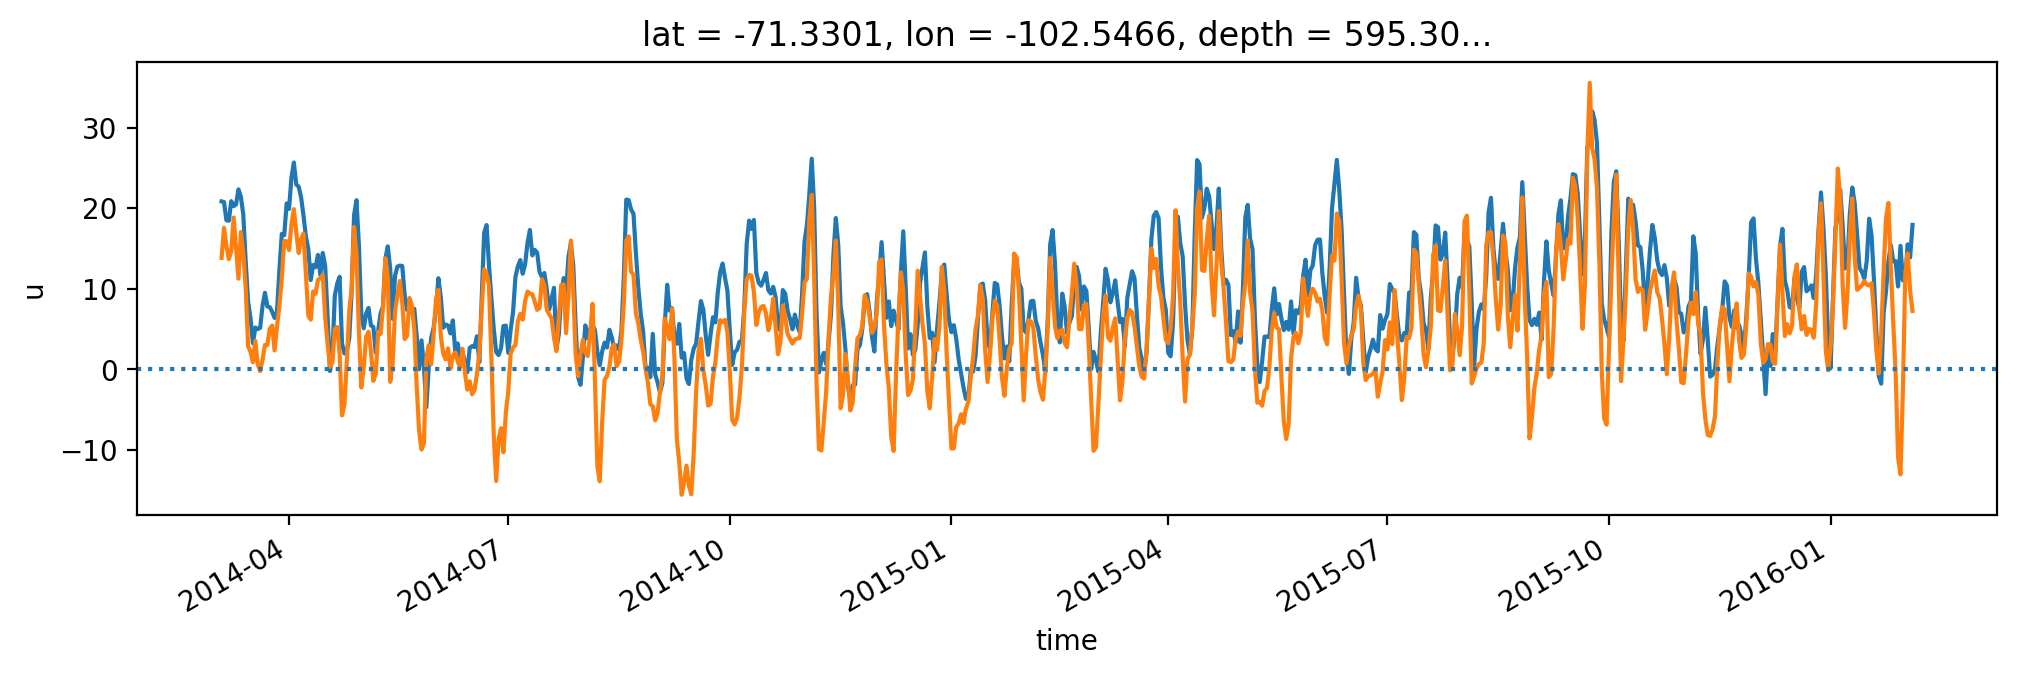

In [8]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
troughE1_d.u.plot()
#troughE1_d.v.plot()
ax.plot(troughE1_d.time, troughE1_d.v*(-1))
ax.axhline(0, ls=':')

In [9]:
# Distance in metres between the moorings in the central trough
dist1 = gsw.distance([istar1.lon.values, troughW0.lon.values], 
             [istar1.lat.values, troughW0.lat.values])

dist2 = gsw.distance([istar1.lon.values, bsr12_1.lon.values], 
             [istar1.lat.values, bsr12_1.lat.values])

dist3 = gsw.distance([istar1.lon.values, bsr13.lon.values], 
             [istar1.lat.values, bsr13.lat.values])

print("Distance between istar1 and trough W: %s m" % dist1)
print("Distance between istar1 and bsr12: %s m" % dist2)
print("Distance between istar1 and bsr13a: %s m" % dist3)

Distance between istar1 and trough W: [16.35863719] m
Distance between istar1 and bsr12: [1552.5905014] m
Distance between istar1 and bsr13a: [22266.05384808] m


In [10]:
# vel components projected onto rotated frame; daily averages
bsr12_rot = fc.rotate_frame(bsr12_d.u, bsr12_d.v, 54, 'clockwise') #47
bsr13_rot = fc.rotate_frame(bsr13_d.u, bsr13_d.v, 32, 'anticlockwise')#10
istar1_rot = fc.rotate_frame(istar1_d.u, istar1_d.v, 46, 'clockwise') #47
troughW0_rot = fc.rotate_frame(troughW0_d.u, troughW0_d.v, 53, 'clockwise') #47
troughW1_rot = fc.rotate_frame(troughW1_d.u, troughW1_d.v, 53, 'clockwise') #47
troughE0_rot = fc.rotate_frame(troughE0_d.u, troughE0_d.v, 26, 'clockwise') #45
troughE1_rot = fc.rotate_frame(troughE1_d.u, troughE1_d.v, 26, 'clockwise') #45

# concatenate moorings in the PITW/central trough
#central0_rot = xr.concat([bsr12_rot, bsr13_rot, istar1_rot, troughW1_rot], dim='time')
#central_rot = central0_rot.resample(time='1D').mean()

In [11]:
arr1 = troughW1_rot.u
arr2 = troughE1_rot.u
pearsonr_irreg(arr1, arr2)

<xarray.DataArray 'time' ()>
array('2014-03-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    lat      float64 -71.33
    lon      float64 -102.5
    depth    float64 595.3
    time     datetime64[ns] 2014-03-04 <xarray.DataArray 'time' ()>
array('2016-02-04T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    lat      float64 -71.33
    lon      float64 -102.5
    depth    float64 595.3
    time     datetime64[ns] 2016-02-04


(0.37973783433186703, 1.55664146821154e-25)

In [12]:
def anom(arr):
    print(arr.mean())
    return arr - arr.mean() 

In [13]:
# concatenate moorings in the PITW/central trough
# subtract the time mean of every moooring before merging them 
bsr12_anom = anom(bsr12_rot)
bsr13_anom = anom(bsr13_rot)
istar1_anom = anom(istar1_rot)
tw1_anom = anom(troughW1_rot)

ctd0 = xr.concat([bsr12_anom, bsr13_anom, istar1_anom, tw1_anom], dim='time')
ctd = ctd0.resample(time='1D').mean()
ctm0 = ctd.resample(time='1MS').mean()

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 -71.58
    lon      float64 -113.0
    depth    float64 553.3
Data variables:
    u        float64 5.28
    v        float64 -0.1527
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 -71.39
    lon      float64 -113.4
    depth    int64 338
Data variables:
    u        float64 2.214
    v        float64 -0.2939
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 -71.56
    lon      float64 -113.0
    depth    float64 581.3
Data variables:
    u        float64 5.279
    v        float64 0.001024
<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 -71.56
    lon      float64 -113.0
    depth    float64 555.3
Data variables:
    u        float64 6.194
    v        float64 0.007721


### Apply a 15-day running mean filter

In [14]:
def avg_filt(moor, ndays):
    """
    Applies a daily filter to hourly mooring data
    Returns the filtered signal and a monthly average
    """
    monthly = moor.resample(time='1MS').mean()

    daily_filt = moor.rolling(time=ndays, min_periods=1).mean()
    monthly_filt = daily_filt.resample(time='1M').mean()
    
    monthly['uf'] = ('time', monthly_filt.u)
    monthly['vf'] = ('time', monthly_filt.v)
    
    return daily_filt, monthly

In [15]:
nfilt = 15

ct_df, ctm = avg_filt(ctd, nfilt)
bsr12_df, bsr12_m = avg_filt(bsr12_rot, nfilt)
bsr13_df, bsr13_m = avg_filt(bsr13_rot, nfilt)
istar1_df, istar1_m = avg_filt(istar1_rot, nfilt)
tw1_df, tw1_m = avg_filt(troughW1_rot, nfilt)
tw0_df, tw0_m = avg_filt(troughW0_rot, nfilt)
te1_df, te1_m = avg_filt(troughE1_rot, nfilt)
te0_df, te0_m = avg_filt(troughE0_rot, nfilt)

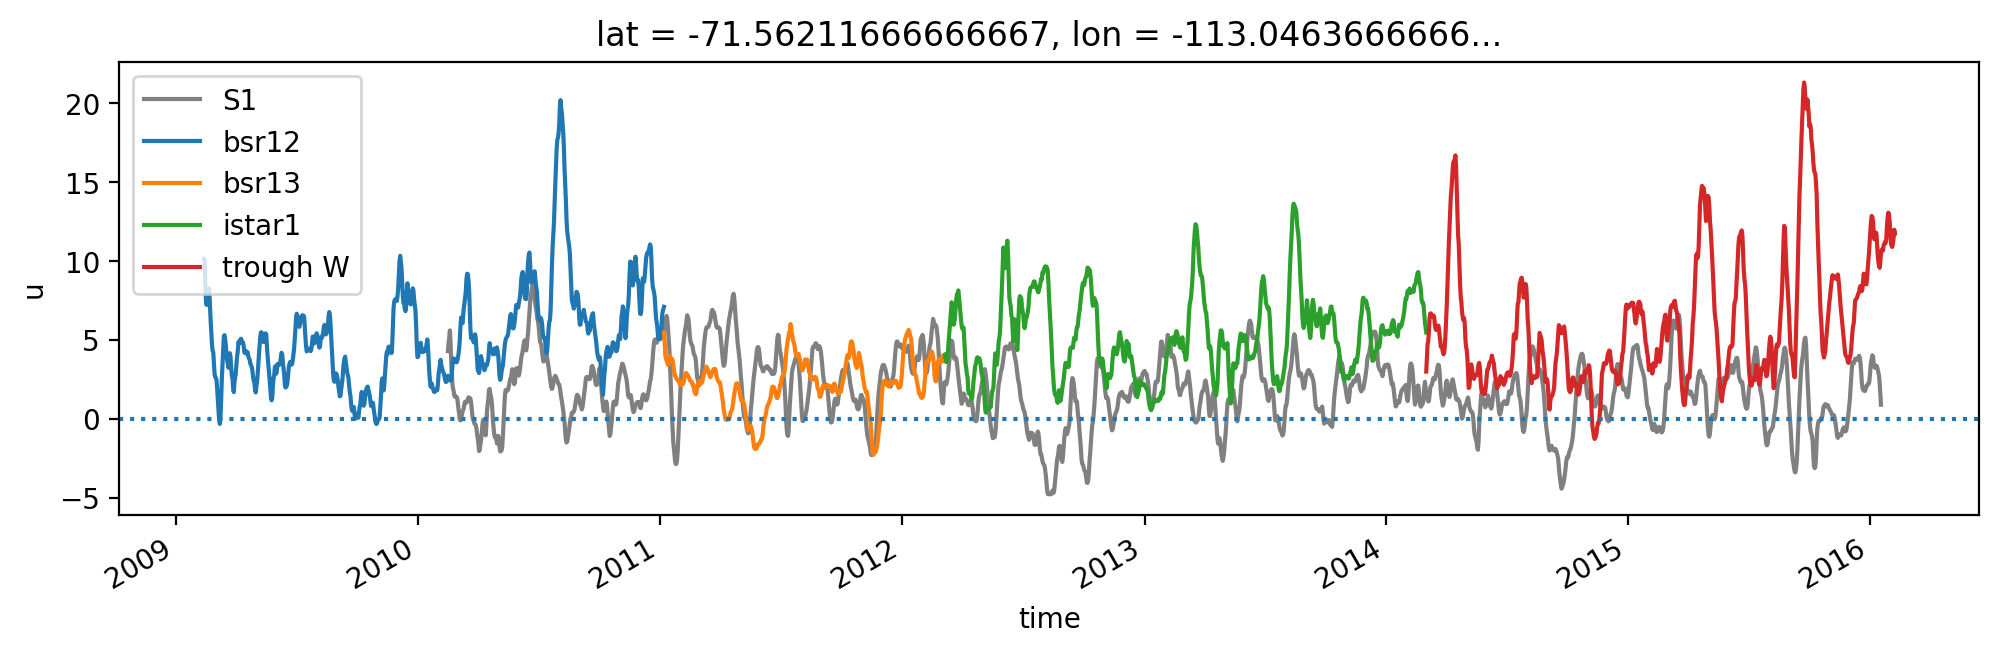

In [16]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(ts1.time, ts1.rot_u*1e2, c='grey', label="S1")
bsr12_df.u.plot(label='bsr12')
bsr13_df.u.plot(label='bsr13')
istar1_df.u.plot(label='istar1')
tw1_df.u.plot(label='trough W')
ax.axhline(0, ls=':')
ax.legend()

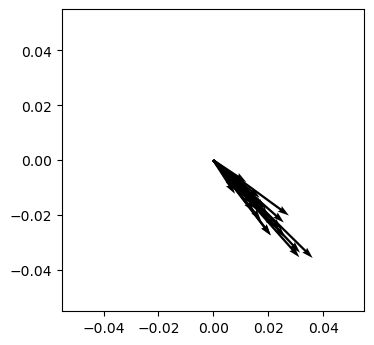

In [17]:
var = istar1_d.resample(time='1MS').mean()
fig, ax = plt.subplots(dpi=100)
for i in range(len(var.u)):
    ax.quiver(0,0,var.u[i], var.v[i], scale=21)
ax.set_aspect('equal')


In [ ]:
# compute speed - daily
s1_speed = ts1.u**2 + ts1.v**2
s1_speed_crop = s1_speed.sel(time=slice(s1_start, s1_end))
#s1_trend, s1_det = fc.trend_ci(s1_speed_crop, 0.95)

s1_speed_anom = s1_speed_crop - s1_speed_crop.mean() 
s1_speed_stand = s1_speed_anom / s1_speed_anom.std(ddof=1)

s1_speed_stand.plot()

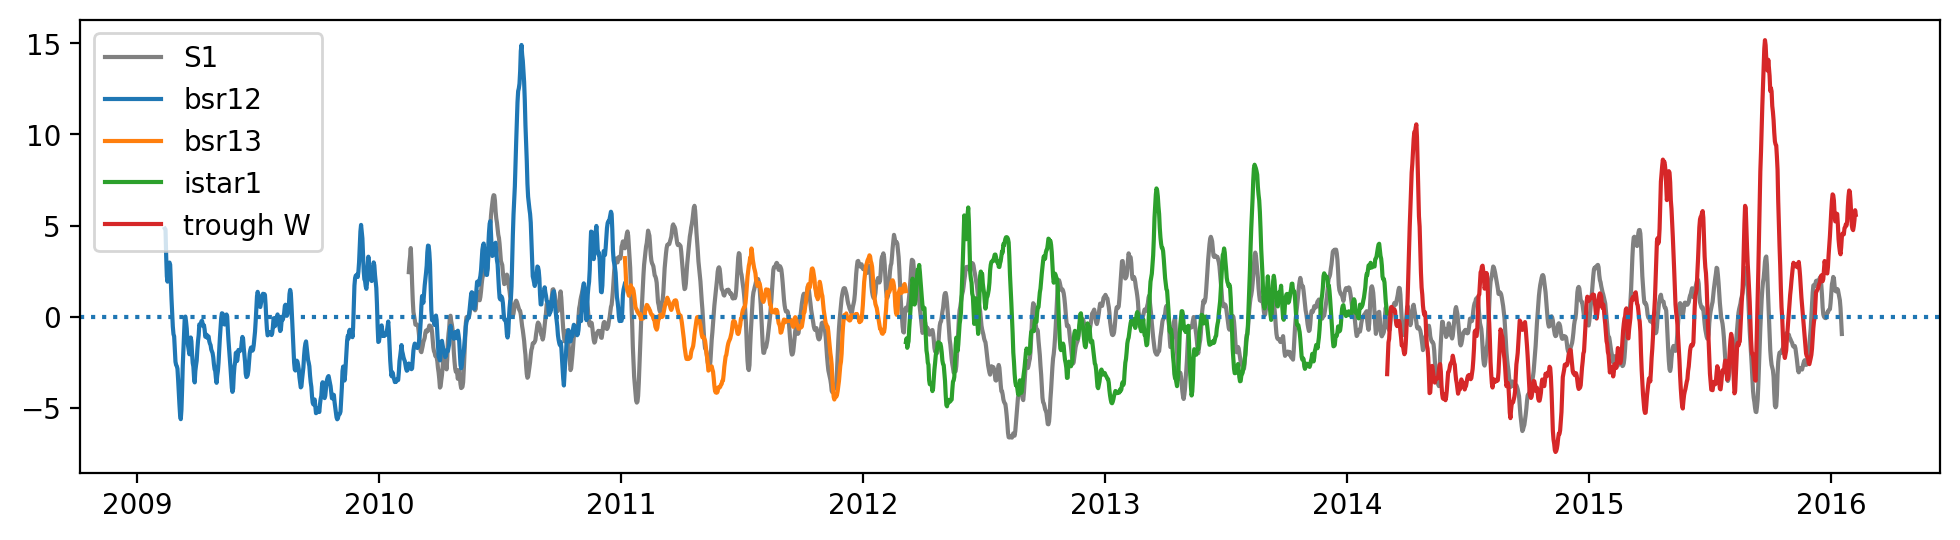

In [18]:
# subtract time mean from every mooring before plotting

fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(ts1.time, (ts1.rot_u-ts1.rot_u.mean())*1e2, c='grey', label="S1")
ax.plot(bsr12_df.time, bsr12_df.u-bsr12_df.u.mean(), label='bsr12')
ax.plot(bsr13_df.time, bsr13_df.u-bsr13_df.u.mean(), label='bsr13')
ax.plot(istar1_df.time, istar1_df.u-istar1_df.u.mean(), label='istar1')
ax.plot(tw1_df.time, tw1_df.u-tw1_df.u.mean(), label='trough W')
ax.axhline(0, ls=':')
ax.legend()

In [19]:
print(fc.pearsonr_nan(ts1.rot_u, bsr12_df.u))
print(fc.pearsonr_nan(ts1.rot_u, bsr13_df.u))
print(fc.pearsonr_nan(ts1.rot_u, istar1_df.v))
print(fc.pearsonr_nan(ts1.rot_u, tw1_df.u))

(0.13189508395101807, 0.017015230068528946)
(0.14658895145558964, 0.002449674874684884)
(0.22408993327716037, 9.988762366792495e-10)
(0.12806370862031996, 0.0007671375866179947)


(-6.0, 22.0)

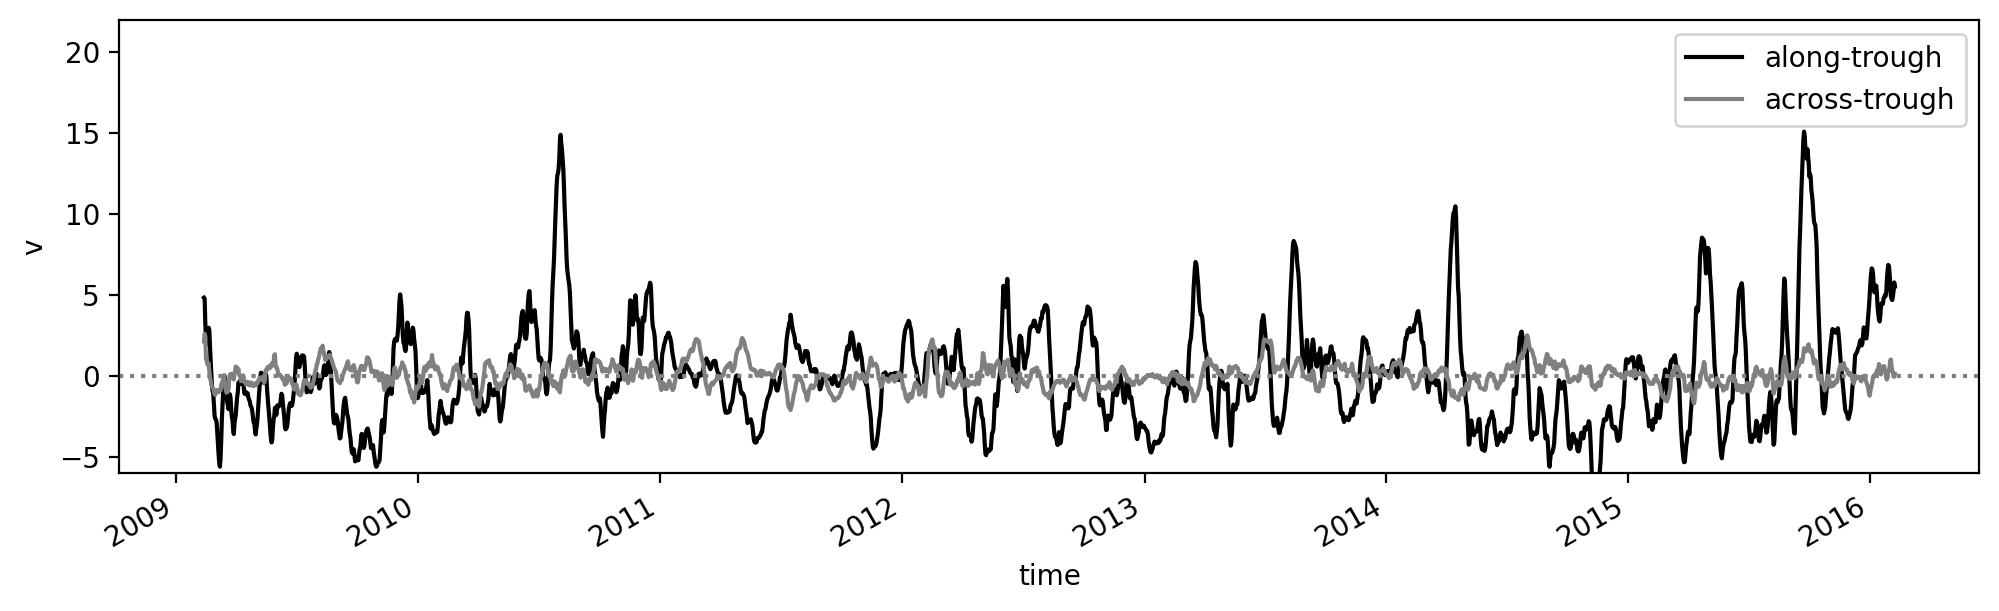

In [20]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
#istar1_df.u.plot(c='g')
#tw0_df.u.plot(c='crimson')
#tw1_df.u.plot(c='orange')
#te0_df.u.plot(c='k')
#te1_df.u.plot(c='g')
ct_df.u.plot(c='k', label='along-trough')
ct_df.v.plot(c='grey', label='across-trough')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylim(-6, 22)

trough E and trough W corr: 0.6803942518820382 and p-value: 0.00025366509660356947


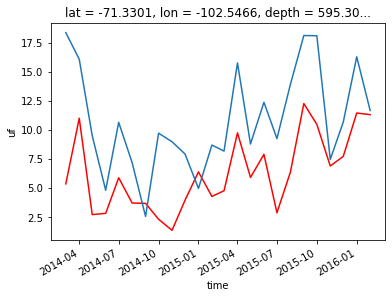

In [21]:
fig, ax = plt.subplots()
tw1_m.uf.plot(c='r')
te1_m.uf.plot()

r, p = fc.pearsonr_nan(tw1_m.u, te1_m.uf)
print("trough E and trough W corr: %s and p-value: %s" % (r, p))

In [22]:
# crop incomplete months from the monthly data
ct_start = '2009-02-01'
ct_end = '2016-01-31'

te_start = '2014-04-01'
te_end = '2016-01-01'

ctm = ctm.sel(time=slice(ct_start, ct_end))
tem = te1_m.sel(time=slice(te_start, te_end))

In [23]:
# anomalies
ctm_crop = ctm.sel(time=slice('2009-02-01', '2016-01-31'))
ctm_anom = ctm_crop - ctm_crop.mean()
ctm_mclim = ctm_crop.groupby('time.month') - ctm_crop.groupby('time.month').mean()

tem_anom = tem - tem.mean("time")
tem_mclim = tem.groupby("time.month") - tem.groupby("time.month").mean()


In [24]:
print("no lag:", pearsonr(ctm_anom.uf.sel(time=slice('2010-03-01', '2015-12-31')),
         uc_max_anom.sel(time=slice('2010-03-01', '2015-12-31'))))
print("CT+1 month:", pearsonr(ctm_anom.uf.sel(time=slice('2010-04-01', '2016-01-31')),
         uc_max_anom.sel(time=slice('2010-03-01', '2015-12-31'))))
print("CT-1 month:", pearsonr(ctm_anom.uf.sel(time=slice('2010-02-01', '2015-11-30')),
         uc_max_anom.sel(time=slice('2010-03-01', '2015-12-31'))))
print("S1 lags behind  central trough and it is in phase")

no lag: (0.1481753012998005, 0.22088721229078861)
CT+1 month: (0.28337709550917656, 0.017446324258098268)
CT-1 month: (-0.14301279197818295, 0.23757530719742995)
S1 lags behind  central trough and it is in phase


NameError: name 'central0d' is not defined

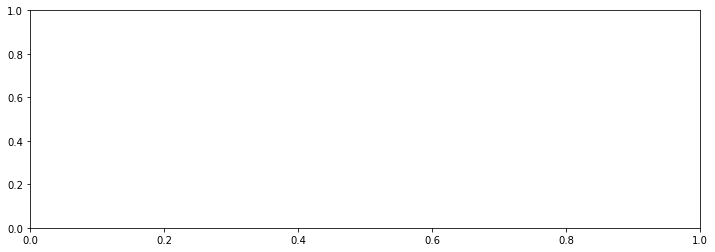

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
central0d.u.plot(c='lightgrey')
ct0d_filt.u.plot(c='k', lw=1)
#ct0m.u.plot.step(c='m', lw=2)

# month ticks
xtim = pd.to_datetime(ct0m.time.values) 
ax.set_xticks(xtim, minor=True)
ax.grid(True, which='minor', c='dimgrey',ls=':', lw=.5)
ax.grid(True, which='major', c='dimgrey',ls=':', lw=.5)
ax.set_xlim(xtim[0] - timedelta(days=60), xtim[-1] + timedelta(days=60))

ax.set_ylabel('cm/s')
ax.set_xlabel(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
#fig.savefig(figdir + 'pig_uc_filt.png')

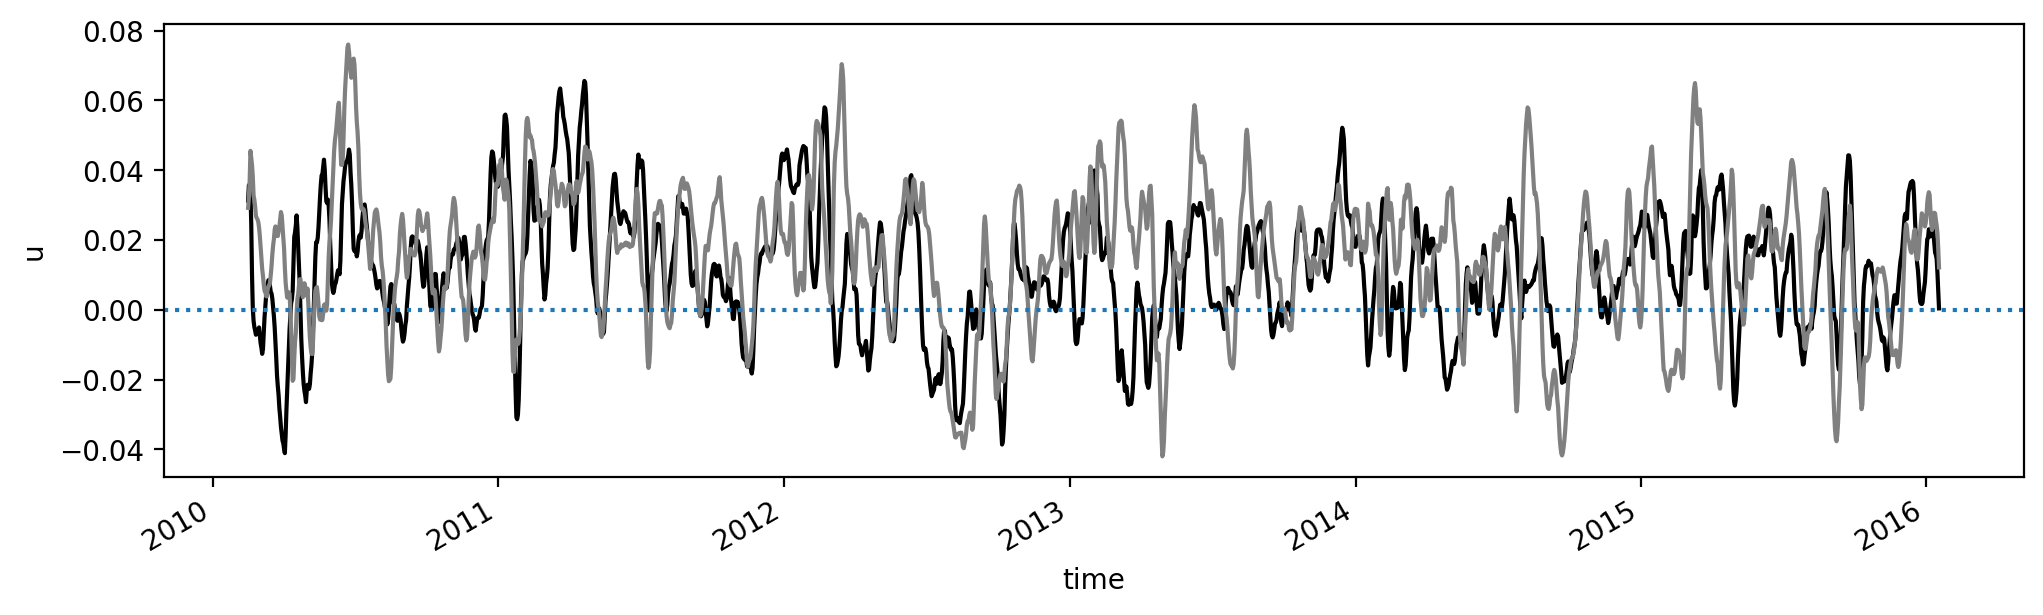

In [26]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ts1.u.plot(c='k')
ax.plot(ts1.time, ts1.v*(-1), c='grey')
ax.axhline(0, ls=':')

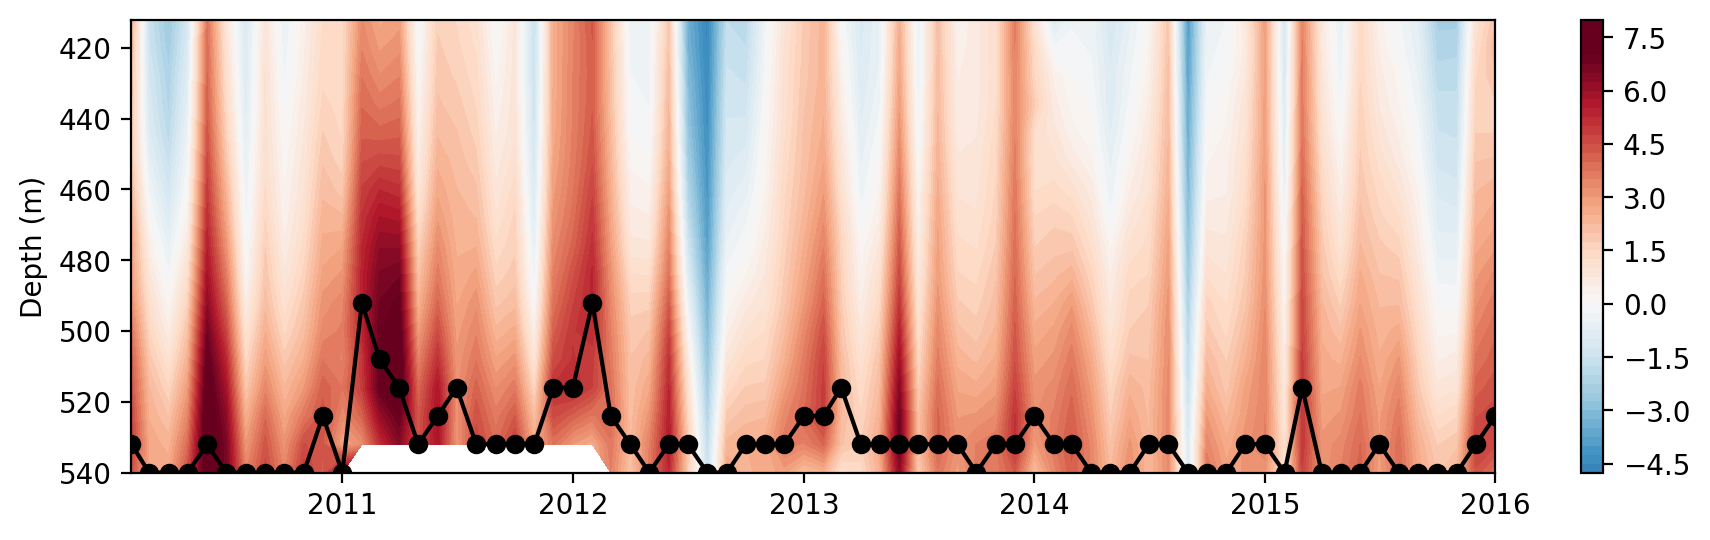

In [27]:
xx, yy = np.meshgrid(mts1_dep.time.values, mts1_dep.depth.values)

fig,ax = plt.subplots(figsize=(11,3), dpi=200)
cs = ax.contourf(xx, yy, mts1_dep.rot_u.T*1e2, cmap='RdBu_r', vmax=7, vmin=-7, levels=50)
ax.plot(depth_vmax.time, depth_vmax.values, marker='o', c='k')
ax.invert_yaxis()
ax.set_ylabel("Depth (m)")
fig.colorbar(cs)

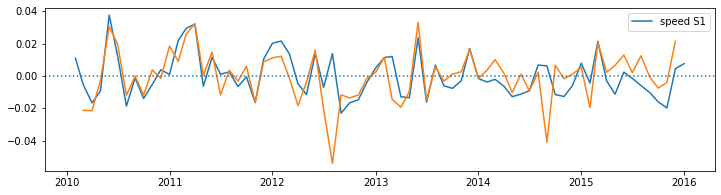

In [28]:
mean_ts1 = np.sqrt(mts1.u**2 + mts1.v**2)
s1_speed = mean_ts1-mean_ts1.mean()
s1_speed_mclim = mean_ts1.groupby("time.month") - mean_ts1.groupby("time.month").mean()

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(mean_ts1.time, s1_speed, label='speed S1')
ax.plot(uc_max_anom.time, uc_max_anom)
ax.axhline(0, ls=':')
ax.legend()

(0.9177855751275689, 5.541511808729681e-29)

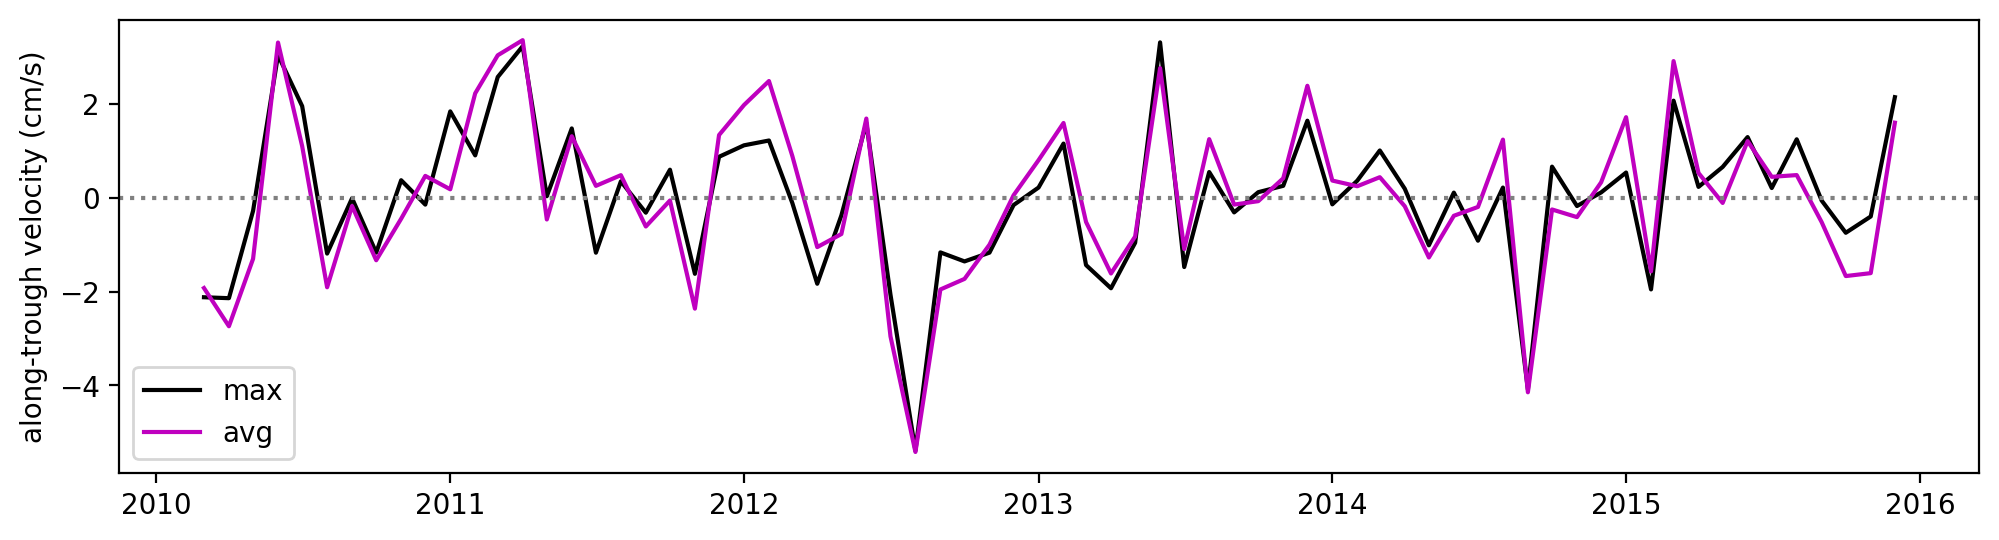

In [12]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(uc_max_anom.time, uc_max_anom*1e2, c='k', label='max')
ax.plot(uc_dep_anom.time, uc_dep_anom*1e2, c='m', label='avg')
ax.legend()
ax.set_ylabel("along-trough velocity (cm/s)")
ax.axhline(0, ls=':', c='grey')

pearsonr(uc_max_anom, uc_dep_anom)

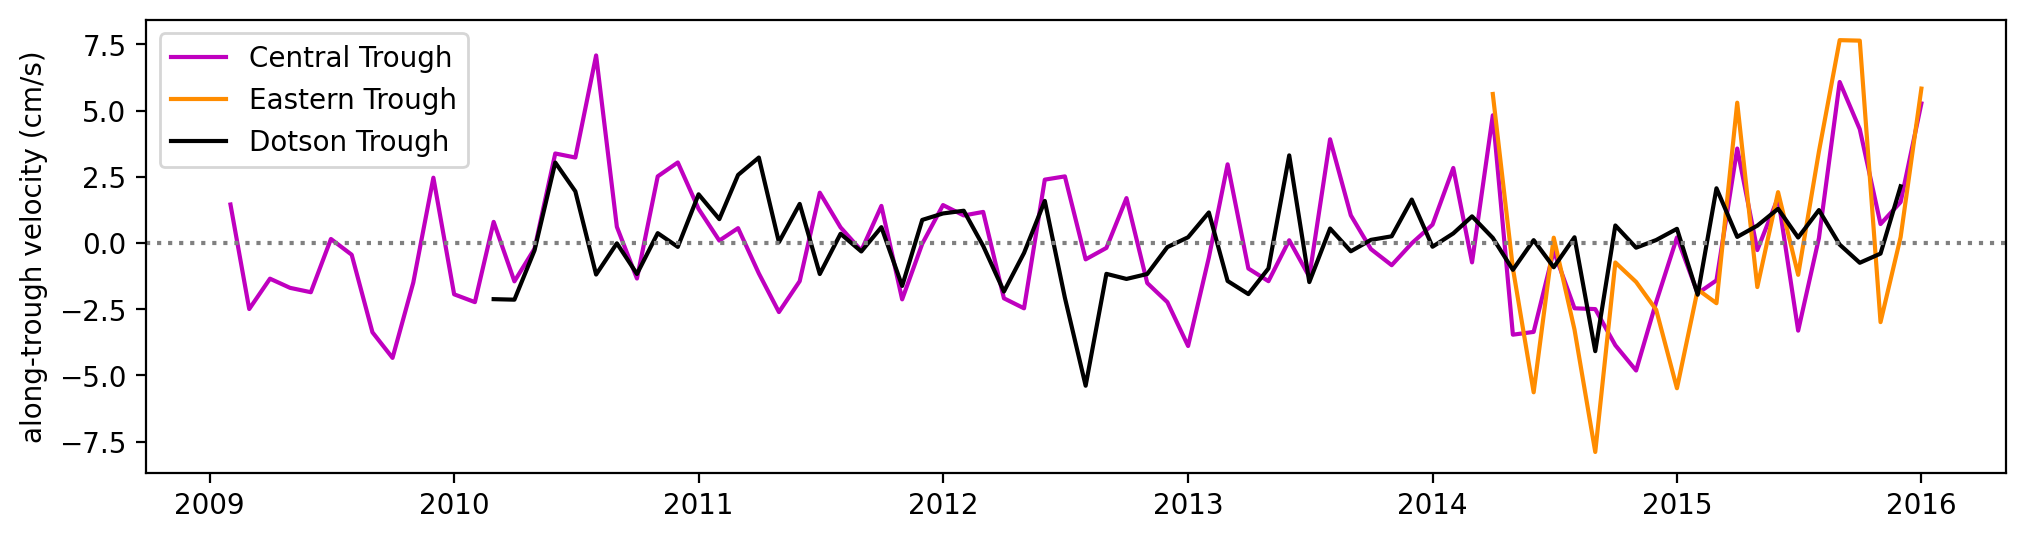

In [29]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(ctm.time, ctm_anom.uf, c='m', label='Central Trough')
ax.plot(tem.time, tem_anom.uf, c='darkorange', label='Eastern Trough')
#ax.plot(uc_dep_crop.time, uc_dep_crop.rot_u*1e2, c='k', label='Dotson Trough')
ax.plot(uc_max_anom.time, uc_max_anom*1e2, c='k', label='Dotson Trough')
ax.legend()
ax.set_ylabel("along-trough velocity (cm/s)")
ax.axhline(0, ls=':', c='grey')

In [30]:
r, p = fc.pearsonr_nan(uc_dep_crop.rot_u.sel(time=slice('2010-03-01', None)),
                       ctm.uf.sel(time=slice(None, '2015-12-31')))
print("trough E and trough W corr: %s and p-value: %s" % (r, p))

trough E and trough W corr: 0.1327649357292421 and p-value: 0.27323224232573895


(-6.0, 22.0)

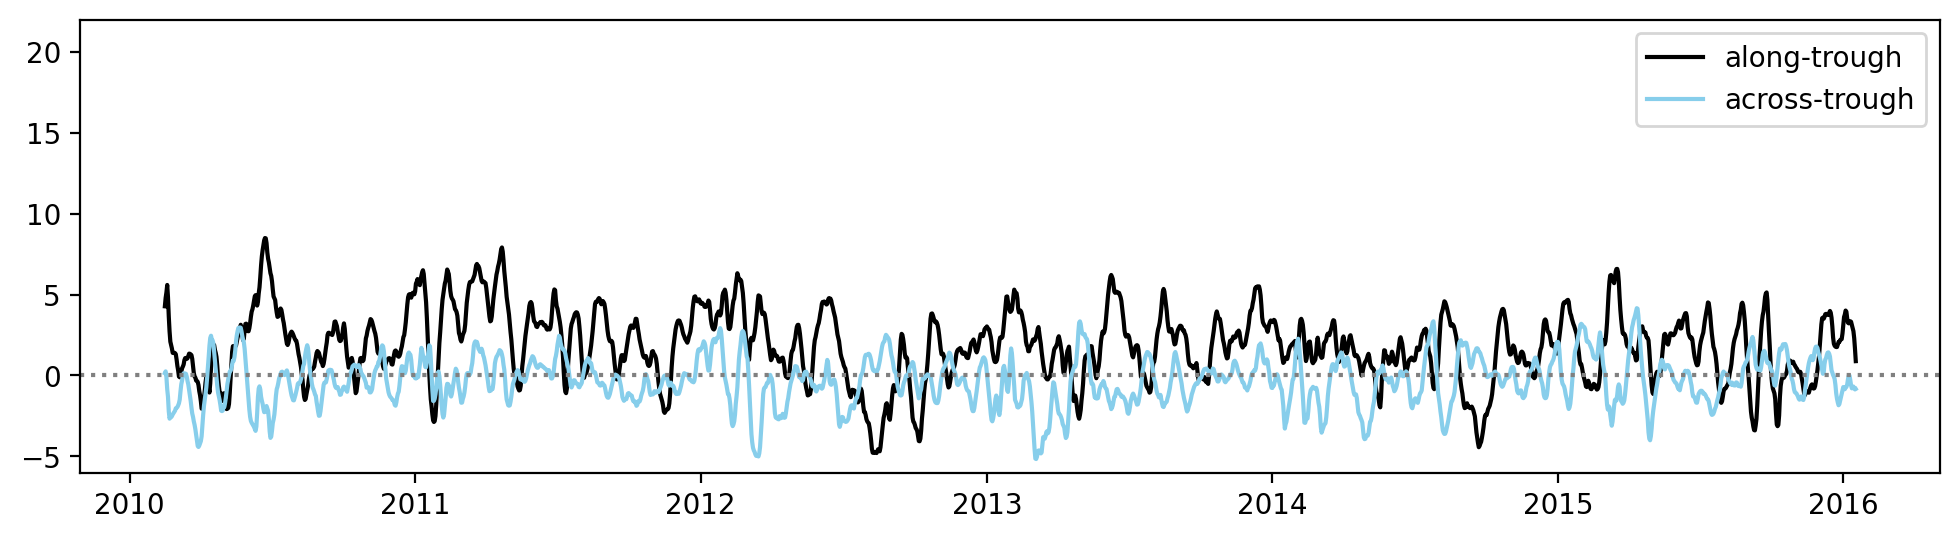

In [31]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(ts1.time, ts1.rot_u*1e2, c='k', label='along-trough')
ax.plot(ts1.time, ts1.rot_v*1e2, c='skyblue', label='across-trough')
#ct0d_filt.u.plot(c='k', label='along-trough')
#ct0d_filt.v.plot(c='grey', label='across-trough')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylim(-6, 22)

(-6.0, 32.0)

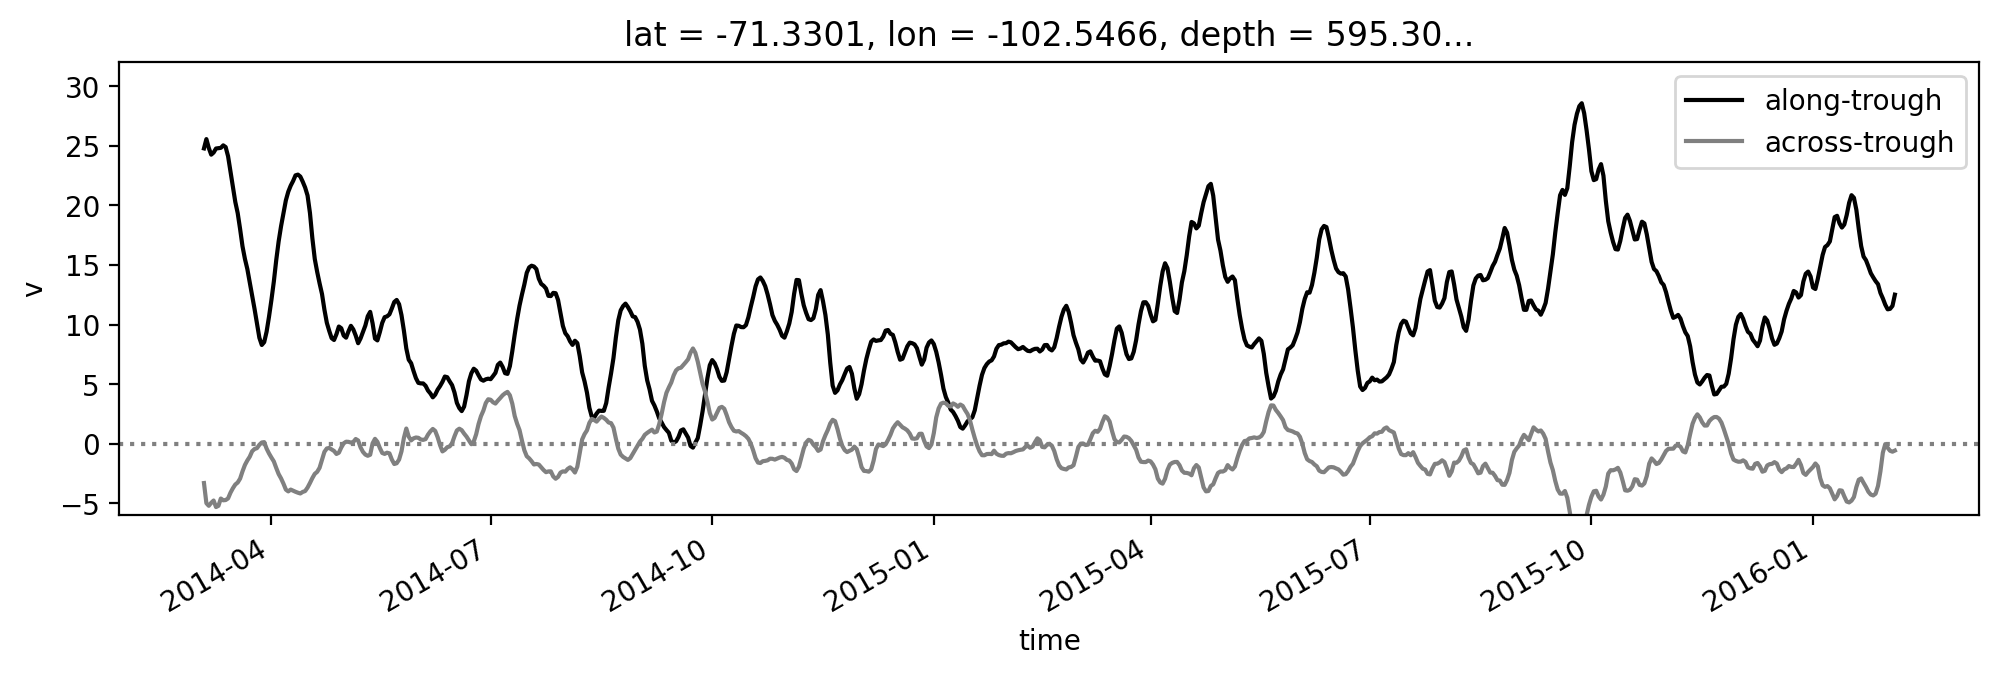

In [32]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
te1_df.u.plot(c='k', label='along-trough')
te1_df.v.plot(c='grey', label='across-trough')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylim(-6, 32)

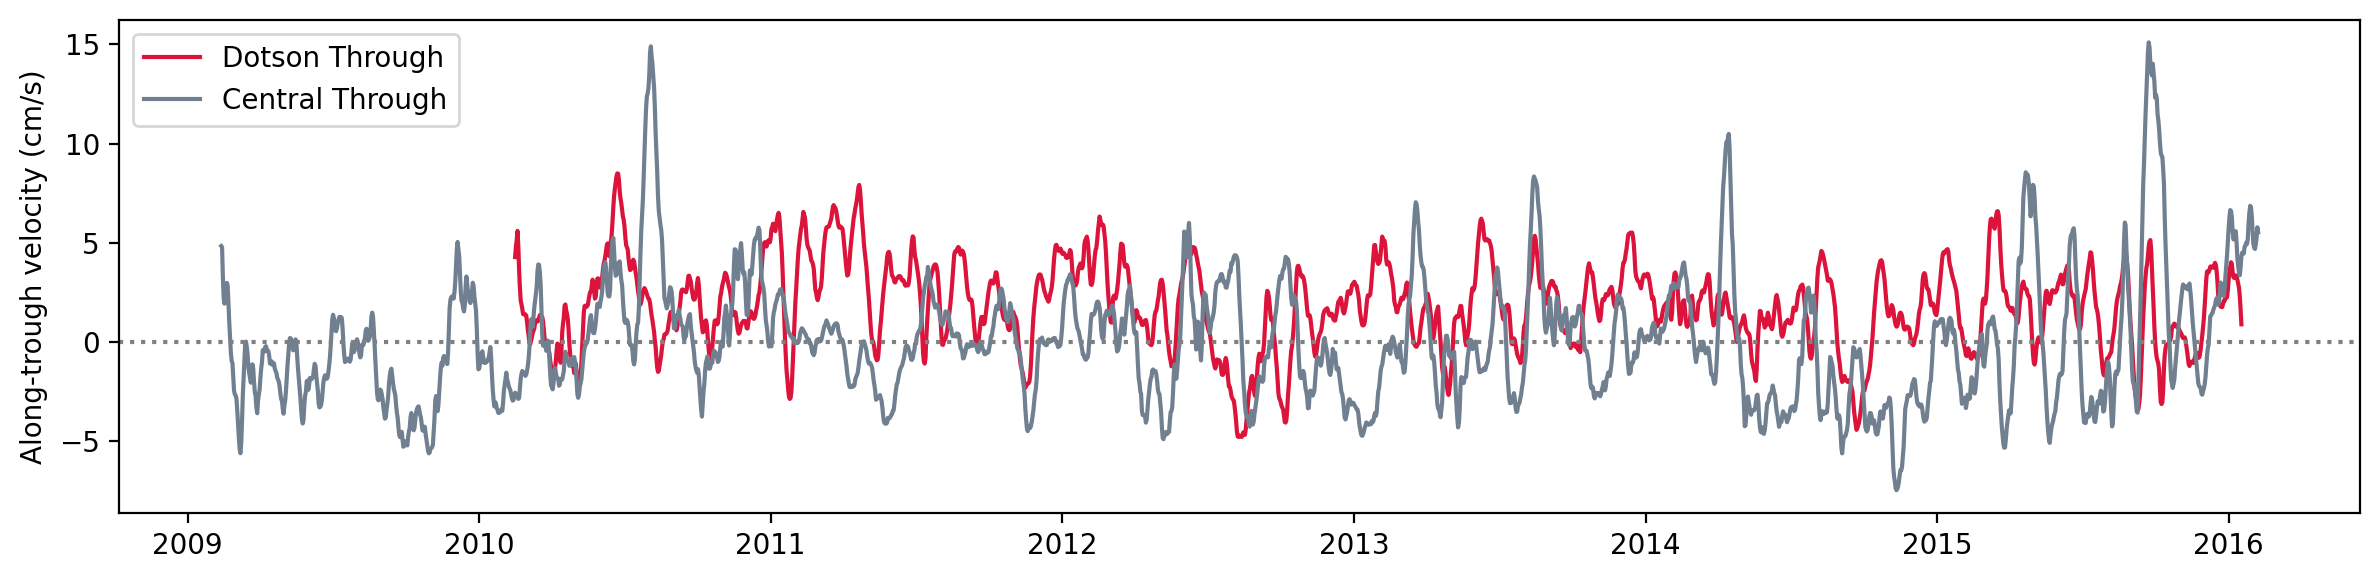

In [33]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=200)
ax.plot(ts1.time, ts1.rot_u*1e2, c='crimson', label='Dotson Through')
ax.plot(ct_df.time, ct_df.u, c='slategrey', label='Central Through')
#ax.plot(te1_df.time, te1_df.u, c='darkorange', label='Eastern Through')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel('Along-trough velocity (cm/s)')
plt.tight_layout()

#print(fc.pearsonr_nan(ts1.rot_u.copy(), ct0d_filt.u.sel(time=slice('2010-03-01', '2015-12-01')).copy()))
#fig.savefig(figdir + 'moors_daily_filt.png')

### lagged corerelations of daily mooring data

In [34]:
def add_daily_lag(var, lag):
    var_lag = var.shift(time=lag)    
    return var_lag

In [35]:
a = ts1.rot_u.sel(time=slice('2010-03-01', '2015-12-31')).copy()
b = ct_df.u.sel(time=slice('2010-03-01', '2015-12-31')).copy()
corr_i, pval_i = [np.ones((400,)) for _ in range(2)]

i = 0
for lag in range(-200, 200):
    a_lag = add_daily_lag(a.copy(), lag)
    corr_i[i], pval_i[i] = fc.pearsonr_nan(b.copy(), a_lag)
    
    i += 1

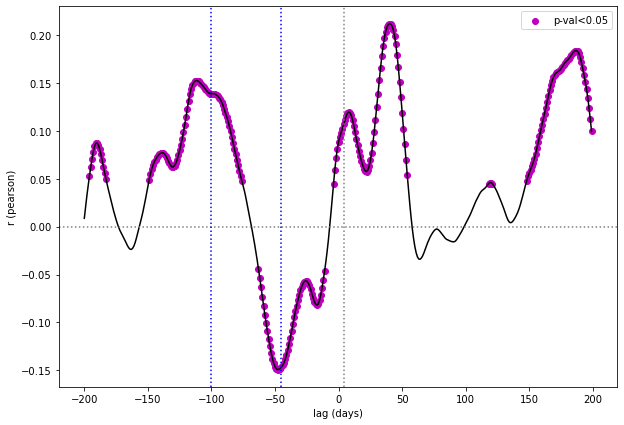

In [36]:
fig, ax= plt.subplots(figsize=(10,7))
ax.plot(np.arange(-200, 200), corr_i, c='k')
ax.scatter(np.arange(-200, 200)[pval_i<0.05], corr_i[pval_i<0.05], c='m', label='p-val<0.05')
ax.axhline(0, ls=':', c='grey')
ax.axvline(4, ls=':', c='grey')
ax.axvline(-45, ls=':', c='b')
ax.axvline(-100, ls=':', c='b')
ax.set_xlabel('lag (days)')
ax.set_ylabel('r (pearson)')
ax.legend()

#### any change if the time means are removed (they might be removed in the correlation already)

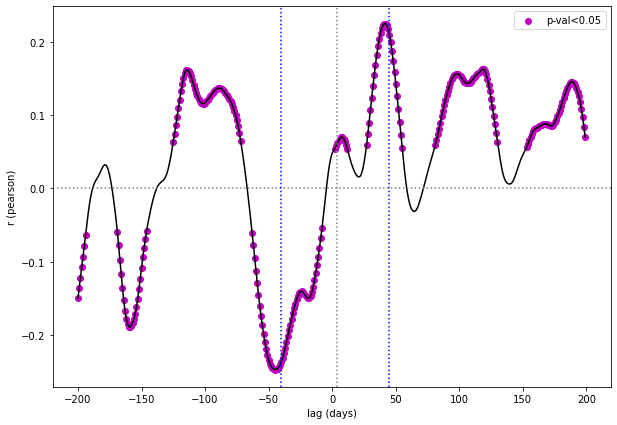

In [54]:
a = ts1.rot_u.sel(time=slice('2012-04-01', '2015-12-31'))
b = ct_df.u.sel(time=slice('2012-04-01', '2015-12-31'))

a_anom = a - a.mean('time')
b_anom = b - b.mean('time')

corr_i, pval_i = [np.ones((400,)) for _ in range(2)]

i = 0
for lag in range(-200, 200):
    a_lag = add_daily_lag(a_anom.copy(), lag)
    corr_i[i], pval_i[i] = fc.pearsonr_nan(b_anom.copy(), a_lag)
    
    i += 1
    
    
fig, ax= plt.subplots(figsize=(10,7))
ax.plot(np.arange(-200, 200), corr_i, c='k')
ax.scatter(np.arange(-200, 200)[pval_i<0.05], corr_i[pval_i<0.05], c='m', label='p-val<0.05')
ax.axhline(0, ls=':', c='grey')
ax.axvline(4, ls=':', c='grey')
ax.axvline(-40, ls=':', c='b')
ax.axvline(45, ls=':', c='b')
ax.set_xlabel('lag (days)')
ax.set_ylabel('r (pearson)')
ax.legend()

fig.savefig(figdir + 'moors_daily_filt_lagcorr.png')

(0.02533266923431398, 0.8044418240500171)


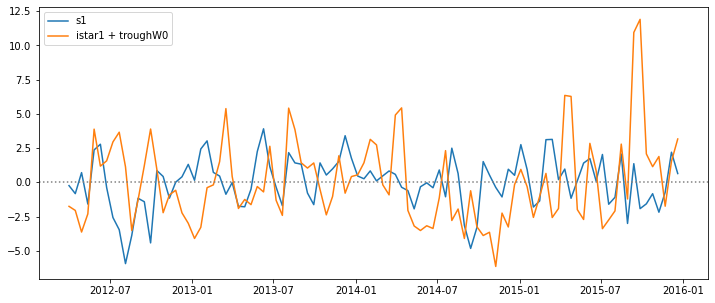

In [62]:
a0 = ts1.rot_u.sel(time=slice('2012-04-01', '2015-12-31'))
b0 = ct_df.u.sel(time=slice('2012-04-01', '2015-12-31'))

a = a0.copy().resample(time='14D').mean()
b = b0.copy().resample(time='14D').mean()

a_anom = a - a.mean('time')
b_anom = b - b.mean('time')

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(a_anom.time, a_anom*1e2, label='s1')
ax.plot(b_anom.time, b_anom, label='istar1 + troughW0')
ax.axhline(0, ls=':', c='grey')
ax.legend()

print(fc.pearsonr_nan(a_anom.copy(), b_anom.copy()))

(0.10518233991622747, 0.3897130574301039)

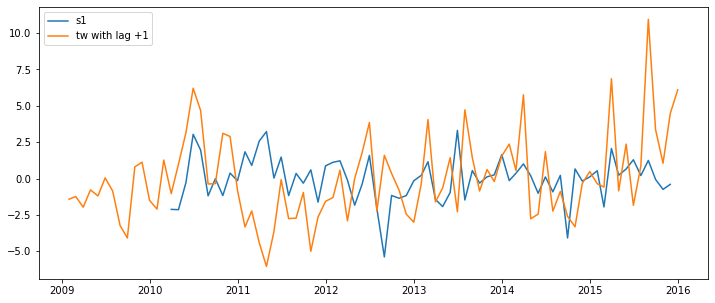

In [66]:
s1_lag = fc.add_monthly_lag(uc_max_anom.copy(), 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(s1_lag.time, s1_lag*1e2, label='s1')
ax.plot(ctm_anom.time, ctm_anom.u, label='tw with lag +1')
ax.legend()

fc.pearsonr_nan(s1_lag.copy(), ctm_anom.u.copy())

(-0.2095020471359916, 0.0840434957785196)

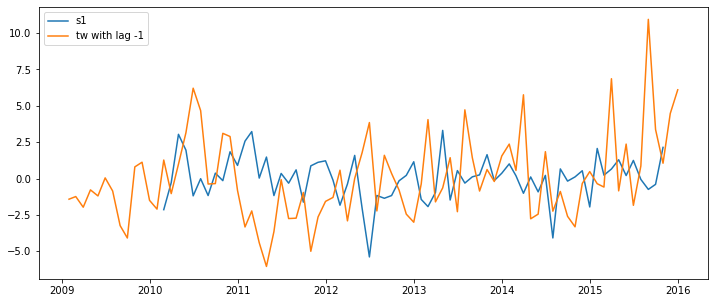

In [67]:
s1_lag = fc.add_monthly_lag(uc_max_anom.copy(), -1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(s1_lag.time, s1_lag*1e2, label='s1')
ax.plot(ctm_anom.time, ctm_anom.u, label='tw with lag -1')
ax.legend()

fc.pearsonr_nan(s1_lag.copy(), ctm_anom.u.copy())

In [63]:
import gsw

dist = gsw.distance([-116.358, -113.0], [-72.468, -71.56])

print("Distance (km) between S1 and PITW: ", dist/1e3)

time_s = 45 * 24 * 3600 # seconds
speed = dist / time_s

print("Hypothetical wave speed: (m/s)", speed)

Distance (km) between S1 and PITW:  [153.21844395]
Hypothetical wave speed: (m/s) [0.03940804]
